In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import sklearn
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model.coordinate_descent import ConvergenceWarning
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from sklearn import metrics

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
def notEmpty(s):
    return s != ''

In [3]:
## 设置字符集，防止中文乱码
mpl.rcParams['font.sans-serif']=[u'simHei']
mpl.rcParams['axes.unicode_minus']=False
## 拦截异常
warnings.filterwarnings(action = 'ignore', category=ConvergenceWarning)

In [14]:
## 加载数据
names = ['CRIM','ZN', 'INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT']
path = "G:/BigDataNote/testData/household_power_consumption/boston_housing.data"
## 由于数据文件格式不统一，所以读取的时候，先按照一行一个字段属性读取数据，然后再安装每行数据进行处理
fd = pd.read_csv(path, header=None)
data = np.empty((len(fd), 14))
for i, d in enumerate(fd.values):
    d = map(float, filter(notEmpty, d[0].split(' ')))
    data[i] = d
## 分割数据
x, y = np.split(data, (13,), axis=1)
y = y.ravel() # 转换格式

print "样本数据量:%d, 特征个数：%d" % x.shape
print "target样本数据量:%d" % y.shape[0]

样本数据量:506, 特征个数：13
target样本数据量:506


In [16]:
## Pipeline常用于并行调参
models = [
    Pipeline([
            ('ss', StandardScaler()),
            ('poly', PolynomialFeatures()),
            ('linear', RidgeCV(alphas=np.logspace(-3,1,20)))
        ]),
    Pipeline([
            ('ss', StandardScaler()),
            ('poly', PolynomialFeatures()),
            ('linear', LassoCV(alphas=np.logspace(-3,1,20)))
        ])
]

# 参数
parameters = {
    "poly__degree": [3,2,1],
    "poly__interaction_only": [True, False],
    "poly__include_bias": [True, False],
#     fit_intercept:   布尔型，默认为true
#     说明：是否对训练数据进行中心化。如果该变量为false，则表明输入的数据已经进行了中心化，
#     在下面的过程里不进行中心化处理；否则，对输入的训练数据进行中心化处理
    "linear__fit_intercept": [True, False]
}


In [17]:
# 数据分割
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

Ridge算法:最优参数: {'poly__degree': 3, 'linear__fit_intercept': True, 'poly__include_bias': True, 'poly__interaction_only': True}
Ridge算法:R值=0.832
Lasso算法:最优参数: {'poly__degree': 3, 'linear__fit_intercept': False, 'poly__include_bias': True, 'poly__interaction_only': True}
Lasso算法:R值=0.849


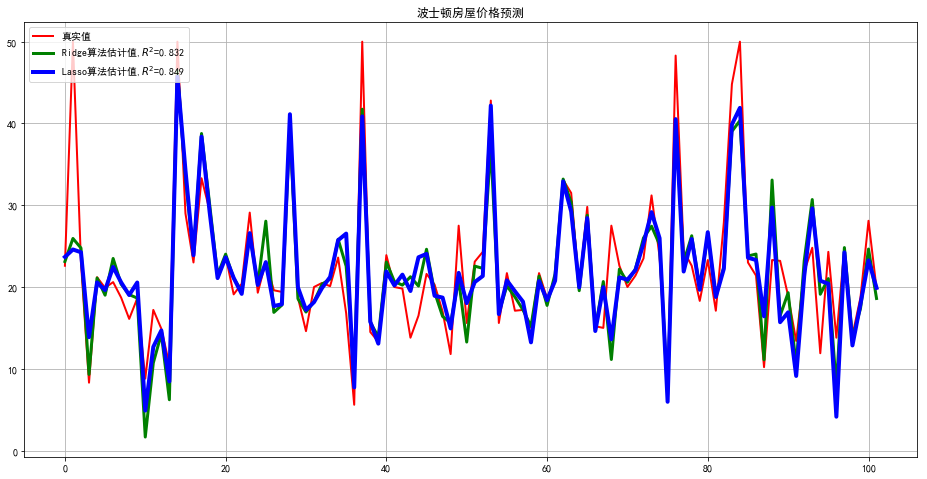

In [21]:
## Lasso和Ridge模型比较运行图表展示
titles = ['Ridge', 'Lasso']
colors = ['g-', 'b-']
plt.figure(figsize=(16,8), facecolor='w')
ln_x_test = range(len(x_test))

plt.plot(ln_x_test, y_test, 'r-', lw=2, label=u'真实值')
for t in range(2):
    # 获取模型并设置参数
    model = GridSearchCV(models[t], param_grid=parameters, n_jobs=1)
    # 模型训练
    model.fit(x_train, y_train)
    # 模型效果值获取（最优参数）
    
    print "%s算法:最优参数:" % titles[t],model.best_params_
    print "%s算法:R值=%.3f" % (titles[t], model.best_score_)
    # 模型预测
    y_predict = model.predict(x_test)
    # 画图
    plt.plot(ln_x_test, y_predict, colors[t], lw = t + 3, label=u'%s算法估计值,$R^2$=%.3f' % (titles[t],model.best_score_))
# 图形显示
plt.legend(loc = 'upper left')
plt.grid(True)
plt.title(u"波士顿房屋价格预测")
plt.show()

In [22]:
## 模型训练 ====> 单个Lasso模型（一阶特征选择）<2参数给定1阶情况的最优参数>
model = Pipeline([
            ('ss', StandardScaler()),
            ('poly', PolynomialFeatures(degree=1, include_bias=True, interaction_only=True)),
            ('linear', LassoCV(alphas=np.logspace(-3,1,20), fit_intercept=False))
        ])
# 模型训练
model.fit(x_train, y_train)


# 模型评测
## 数据输出
print "参数:", zip(names,model.get_params('linear')['linear'].coef_)
print "截距:", model.get_params('linear')['linear'].intercept_
# 'CHAS', -0.0由此可见该特征对LassoCV模型而言无用，模型训练时可以不考虑


参数: [('CRIM', 22.600592809201991), ('ZN', -0.93534557687414621), ('INDUS', 1.0202352850146863), ('CHAS', -0.0), ('NOX', 0.59483138415461478), ('RM', -1.8002644875942353), ('AGE', 2.5861907995357307), ('DIS', -0.064956108249541539), ('RAD', -2.8017533936656509), ('TAX', 1.9343329692037565), ('PTRATIO', -1.7218677875512205), ('B', -2.2762334623842979), ('LSTAT', 0.70288003005515443)]
截距: 0.0


In [ ]:
参数: [('CRIM', 21.135499741068376), ('ZN', -0.0), ('INDUS', -0.0), ('CHAS', -0.0), ('NOX', 0.19539929236955278), ('RM', -0.0), ('AGE', 1.5662356175920531), ('DIS', -0.38131114313786807), ('RAD', -0.69604251661926086), ('TAX', 0.0), ('PTRATIO', -0.0), ('B', -1.5063986238529539), ('LSTAT', 0.0)]
截距: 0.0